# A bernouli Restricted Boltzman Machine

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import display_html 
import pandas as pd
import itertools
import seaborn as sns
plt.rcParams['font.size'] = 14

In [2]:
def load_data(CASE):
    if CASE==0: dname="DATA"
    if CASE==1: dname="DATA_b"

    fname=dname+'/x_RBM_q0.1.dat'
    # loading data: each row is a list of visible units
    # NOTE: data "x" here is named "v" for "visible"
    v = np.loadtxt(fname, delimiter=" ",dtype=int)
    return v , fname

In [3]:
class rbm:
    
    def __init__(self,data,hidden_units=2,SPINS=True,random_seed=2303):
        
        # random seed for reproducibility
        np.random.seed(random_seed)
        
        self.v = data
        self.v0 = np.copy(data)
        self.N = len(self.v)
        self.L = len(self.v[1])
        self.M = hidden_units
        (self.x1,self.y1) = self.create_coord(self.L,0)
        (self.x2,self.y2) = self.create_coord(self.M,1,f=0.7)
        
        #Reassure the user of the loaded data
        print(f'Loaded N={self.N} data instances each containing L={self.L} digits')
        
        # range of each initial weight
        sigma = np.sqrt(4. / float(self.L + self.M))
        
        # initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
        self.w = sigma * np.random.randn(self.L,self.M)
        self.a = sigma * np.random.randn(self.L)
        self.b = np.zeros(self.M)
        
        #initializing adam moments and second moments as zero
        self.m_dw = np.zeros((self.L,self.M))
        self.v_dw = np.zeros((self.L,self.M))
        
        self.m_da = np.zeros(self.L)
        self.v_da = np.zeros(self.L)
        
        self.m_db = np.zeros(self.M)
        self.v_db = np.zeros(self.M)

        if SPINS:  
            # sigmoid takes into account energy difference =2
            self.GAP=2
            # convert 0,1 -> -1,1
            self.v = 2*self.v - 1
            self.vmin=-1
            
            #This generates the possible combinations for the one_hot encoding of -1 and 1 (spins)
            self.v_hot = 2*np.identity(4)-1
            
            #Code to generate all possible combinations of 1 hot encoding to calculate the partition function
            self.v_combs = self.generate_v_combs(self.v_hot)
            #this generates allpossible combs fot h latent neurons
            self.h_combs = x = [[-1,-1,-1],[-1,-1,1],[-1,1,-1],[-1,1,1],[1,-1,-1],[1,-1,1],[1,1,-1],[1,1,1]]

        else:
            self.GAP=1
            self.vmin=0
            
            #This generates the possible combinations for the one_hot encoding of 0 and 1
            self.v_hot = np.identity(4)
            
            #generate combinations of v
            self.v_combs = self.generate_v_combs(self.v_hot)
            self.h_combs = [[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
            
    def generate_v_combs(self,v_hot):
        comb = list(itertools.product(v_hot,repeat=5))
        matrix = np.array([])
        for element in comb:
            row = np.array([])
            for group in element:
                row = np.append(row,group)
            matrix = np.append(matrix,row)    
        return matrix.reshape(1024,20)
            
    def activate(self,v_in,wei,bias,DE):
        
        act = np.dot(v_in, wei) + bias
        n = np.shape(act)
        prob = 1. / (1. + np.exp(-DE*act))
        v_out = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
        
        return v_out
    
    
    def adagrad(self,x,dx,m_dx,lnr_rt,epsilon):
        
        m_dx += dx**2
        
        x += dx*(lnr_rt/np.sqrt(m_dx + epsilon))
        
        return x , m_dx
        
        
    def rmsprop(self,x,dx,m_dx,lnr_rt,epsilon,gamma):
        
        m_dx = gamma*m_dx + (1-gamma)*(dx)**2
        
        lnr_rt = lnr_rt/np.sqrt(m_dx + epsilon)
        
        x += dx*lnr_rt
        
        return x , m_dx


    def adam(self,x,dx,m_dx,v_dx,lnr_rt,t,epsilon,beta1=0.9,beta2=0.999):
        
        #I have to slightly detune t because in the first iteration t=0 the bias correction blows to infinity
        if t<1:
            t=(1e-4)
        
        ## momentum beta 1
        m_dx = beta1*m_dx + (1-beta1)*dx

        ## rms beta 2
        v_dx = beta2*v_dx + (1-beta2)*(dx**2)

        ## bias correction
        m_dx_corr = m_dx/(1-beta1**t)
        v_dx_corr = v_dx/(1-beta2**t)
        
        x += lnr_rt*(m_dx_corr/(np.sqrt(v_dx_corr)+epsilon))
        
        return x , m_dx , v_dx
    

    def total_energy(self,v,h):

        return -(np.dot(v,self.a) + np.dot(h,self.b) + np.dot(np.dot(self.w,h),v))

    def partition(self):
        exp_E = 0
        for v in self.v_combs:
            for h in self.h_combs:
                exp_E += np.exp(-self.total_energy(v,h))

        return exp_E
    
    def entropy_calc(self,energy,Z):
        prob = np.exp(-energy)/Z
        return -prob*np.log(prob)

    def one_hot_func(self,h):
        
        vf = np.zeros(20)
        
        # parsing blocks of 4 in the visible layer
        for i in np.arange(0,20,4):
            
            #calc the energies of the one-hot encoding states (v_hot)
            E = np.dot( np.dot(self.w[i:i+4,:],h) + self.a[i:i+4] , self.v_hot)
            
            Z = np.sum(np.exp(E))
        
            #calc the probabilities of v_hot_enc
            prob_v = np.exp(E) / Z
        
            #compare with the cumulative probability distribution and choose a one-hot-encoding state
            prob = np.random.random_sample(1)
            
            if prob < prob_v[0]:
            
                vf[i:i+4] = self.v_hot[0,:]
            
            elif prob < prob_v[0]+prob_v[1]:
            
                vf[i:i+4] = self.v_hot[1,:]
            
            elif prob < prob_v[0]+prob_v[1]+prob_v[2]:
            
                vf[i:i+4] = self.v_hot[2,:]
            
            else:
                
                vf[i:i+4] = self.v_hot[3,:]

        return vf


    def accuracy(self,gen_data):
        block_size=4
        data_acc = np.copy(self.v0)
        pred_acc = np.copy(((gen_data - self.vmin) / (1 - self.vmin)).astype(int))

        # convert one-hot encoding to polar/non-polar flags
        one_per_block = range(0, self.v0.shape[1], block_size)
        for i in one_per_block:
            data_acc[:, i] = np.argmax(data_acc[:, i:(i + block_size)], axis=1)
            pred_acc[:, i] = np.argmax(pred_acc[:, i:(i + block_size)], axis=1)
        data_acc = pd.DataFrame(data_acc[:, one_per_block])
        pred_acc = pd.DataFrame(pred_acc[:, one_per_block])
        thresh = block_size // 2
        data_acc[data_acc < thresh] = 0
        data_acc[data_acc >= thresh] = 'P'
        pred_acc[pred_acc < thresh] = 0
        pred_acc[pred_acc >= thresh] = 'P'
        data_acc.replace(0,'N', inplace=True)
        pred_acc.replace(0,'N', inplace=True)

        correct1=data_acc.iloc[0]  #PNPNP
        correct2=data_acc.iloc[3]  #NPNPN
        a=0
        b=0
        x=len(data_acc)  #len dataset

        for i in range(x):
            if np.all(pred_acc.iloc[i]==correct2) or np.all(pred_acc.iloc[i]==correct1):
                 a=a+1
            if np.all(data_acc.iloc[i]==correct2) or np.all(data_acc.iloc[i]==correct1):
                b=b+1
        error_data = 100*(x-b)/x
        acc_model = 100 - 100*(x-a)/x
        print("Percentage error in data:",100*(x-b)/x,'%')
        print("Accuracy of the models prediction:",np.round(acc_model),'%')
        
        return acc_model


    def train(self,epochs=100,one_hot=True,learning_rate=1.0,power_law=True,batch_size=500,cd=1,optimizer='sgd',verbose=True,epsilon=1e-7,gamma=0.9,keep_best=True):
        
        self.optimizer_title = optimizer
        # learning rate
        l_rate = learning_rate

        # initialize a bunch of lists for storage
        self.energy_model=[]
        self.energy_data=[]
        self.log_likelihood=[]
        self.entropy=[]

        if verbose:
            self.plot_graph(0)
            print('learning rate = ',l_rate)
        
        # minibatch
        self.mini, m = batch_size, 0
        
        # train model
        for epoch in range(epochs):
            
            if verbose:
                print('epoch: ',epoch+1)
                
            # aggregate normalization of batch statistics and learning rate
            l_rate_m = l_rate / self.mini
            
            for k in range(self.N):
                if m==0:
                    # initialize averages in miniblock
                    v_data, v_model = np.zeros(self.L), np.zeros(self.L)
                    h_data, h_model = np.zeros(self.M), np.zeros(self.M)
                    vh_data,vh_model= np.zeros((self.L,self.M)), np.zeros((self.L,self.M))
                    E_data , E_model = 0, 0
                    if verbose:
                        print('=',end='=')

                # positive CD phase: generating h 
                h = self.activate(self.v[k],self.w,self.b,self.GAP)
                #generate fantasy visible layer preserving one_hot_enconding or not
                if one_hot:
                    vf = self.one_hot_func(h)
                else:
                    vf = self.activate(hf,self.w.T,self.a,self.GAP)
                # one more positive CD phase: generating fantasy h from fantasy vf 
                hf = self.activate(vf,self.w,self.b,self.GAP)
                
                # added this line of code to allow for extra CD steps
                if cd>1:
                    for _ in range(cd):
                        # negative CD phase: generating fantasy vf from fantasy hf
                        if one_hot:
                            vf = self.one_hot_func(h)
                        else:
                            vf = self.activate(hf,self.w.T,self.a,self.GAP)
                        # one more positive CD phase: generating fantasy h from fantasy vf 
                        hf = self.activate(vf,self.w,self.b,self.GAP)


                v_data  += self.v[k]
                v_model += vf
                h_data  += h
                h_model += hf
                vh_data += np.outer(self.v[k].T,h)
                vh_model+= np.outer(vf.T,hf)
                E_data += self.total_energy(self.v[k],h)
                E_model += self.total_energy(vf,hf)
                
                
                m += 1
                # minibatch
                if m==self.mini:
                    # gradient of the likelihood: follow it along its positive direction
                    # with a "vanilla" SGD
                    dw = l_rate_m*(vh_data - vh_model)
                    da = l_rate_m*(v_data - v_model)
                    db = l_rate_m*(h_data - h_model)

                    if optimizer=='sgd':
                        
                        self.b = self.b + db
                        
                        self.a = self.a + da
                        
                        self.w = self.w + dw

                    if optimizer=='adam':
                        
                        self.b, self.m_db, self.v_db = self.adam(self.b, db, self.m_db, self.v_db, l_rate, epoch, epsilon)

                        self.a, self.m_da, self.v_da = self.adam(self.a, da, self.m_da, self.v_da, l_rate, epoch, epsilon)

                        self.w, self.m_dw, self.v_dw = self.adam(self.w, dw, self.m_dw, self.v_dw, l_rate, epoch, epsilon)
                    
                    if optimizer=='adagrad':
                        
                        self.b, self.m_db = self.adagrad(self.b, db, self.m_db, l_rate, epsilon)
                        
                        self.a, self.m_da = self.adagrad(self.a, da, self.m_da, l_rate, epsilon)
                        
                        self.w, self.m_dw = self.adagrad(self.w, dw, self.m_dw, l_rate, epsilon)

                    if optimizer=='rmsprop':
                        
                        self.b, self.m_db = self.rmsprop(self.b, db, self.m_db, l_rate, epsilon, gamma)
                        
                        self.a, self.m_da = self.rmsprop(self.a, da, self.m_da, l_rate, epsilon, gamma)
                        
                        self.w, self.m_dw = self.rmsprop(self.w, dw, self.m_dw, l_rate, epsilon, gamma)

                    
                    self.energy_model = np.append(self.energy_model, E_model/self.mini )
                    self.energy_data = np.append(self.energy_data, E_data/self.mini )
                    
                    m=0
                    
                    # decrease the learning rate (here as a power law) if specified or not using adam
                    if power_law and optimizer=='sgd':
                        l_rate = l_rate / (0.01 * l_rate + 1)
                    
                    #just a handmade progress bar
                    if verbose:
                        print('==',end='|')
                    
                    #keep the best weights
                    if keep_best and epoch>0:
                        #maximization of Energy (because of the minus - E)
                        if self.energy_model[-1] < np.amax(self.energy_model):
                            back_up_a = self.a
                            back_up_b = self.b
                            back_up_w = self.w
                        
            #Compute log_likelihood and append it in a list
            Z = self.partition()
            log_likelihood = np.round(-np.mean(self.energy_data) - np.log(Z),3)
            self.log_likelihood = np.append(self.log_likelihood, log_likelihood )
            #Compute entropy
            self.entropy = np.append(self.entropy, self.entropy_calc(np.mean(self.energy_model),Z) )

            # randomize the order of input data
            np.random.shuffle(self.v)
                      
            #verbosity of the training
            if verbose:
                #print('Model-Data Energy difference  = ',np.round(np.abs((E_model-E_data)/self.mini),4))
                print('Log Likelihood =',log_likelihood)
                #print('Entropy =',np.round(self.entropy[-1],6) )
                if epoch%10==9 and power_law:
                    self.plot_graph(epoch+1)
                    print('learning rate = ',l_rate)
        
        if keep_best:
            self.a = back_up_a
            self.b = back_up_b
            self.w = back_up_w

    def is_one(self,cell_value):
        color0 = 'background-color: #bae4bc'
        color1 = 'background-color: #0173b2; color: white'
        if type(cell_value) in [float, int]:
            if cell_value == 1:
                return color1
        return color0


    def generate(self,amplify=10,one_hot=True):
        # original, non-reshuffled data in v0
        v1 = np.zeros_like(self.v0)
        for k in range(self.N):
            # positive CD phase: generating h 
            h = self.activate(self.v0[k],self.w,self.b,amplify*self.GAP)
            # negative CD phase: generating fantasy vf with low T == large GAP
            if one_hot:
                v1[k] = self.one_hot_func(h)
            else:
                v1[k] = self.activate(h,self.w.T,self.a,self.GAP)
        return v1


    def plot_denoised(self,fname,v1,n_rows=12,block_size=4,polar=False):
        
        # difference between fantasy and data
        diff = (v1 - self.v0)/2
        str0 = fname+'_M'+str(self.M)+'-mini'+str(self.mini)
        np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
        np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')

        if polar==False:
            df0 = pd.DataFrame(self.v0[:n_rows])
            df1 = pd.DataFrame(((v1[:n_rows]-self.vmin)/(1-self.vmin)).astype(int))
            df0s = df0.style.set_table_attributes("style='display:inline'")
            df1s = df1.style.set_table_attributes("style='display:inline'")
            df0s.applymap(self.is_one)
            df1s.applymap(self.is_one)
            sty = [dict(selector="caption",props=[("font-size", "150%")])]
            df0s.set_caption('Original').set_table_styles(sty)
            df1s.set_caption('Denoised').set_table_styles(sty)

            display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)
        
        else:
            data = np.copy(self.v0[:n_rows])
            pred = np.copy(((v1[:n_rows] - self.vmin) / (1 - self.vmin)).astype(int))

            # convert one-hot encoding to polar/non-polar flags
            one_per_block = range(0, self.v0.shape[1], block_size)
            for i in one_per_block:
                data[:, i] = np.argmax(data[:, i:(i + block_size)], axis=1)
                pred[:, i] = np.argmax(pred[:, i:(i + block_size)], axis=1)
            data = pd.DataFrame(data[:, one_per_block])
            pred = pd.DataFrame(pred[:, one_per_block])
            thresh = block_size // 2
            data[data < thresh] = 0
            data[data >= thresh] = 'P'
            pred[pred < thresh] = 0
            pred[pred >= thresh] = 'P'
            data.replace(0,'N', inplace=True)
            pred.replace(0,'N', inplace=True)


            # stylistic manipulations
            data = data.style.set_table_attributes("style='display:inline'")
            pred = pred.style.set_table_attributes("style='display:inline'")

            def is_polar(cell_value):
                color0 = 'background-color: #bae4bc'
                color1 = 'background-color: #0173b2; color: white'
                if cell_value == 'P':
                    return color1
                return color0
            data.applymap(is_polar)
            pred.applymap(is_polar)
            sty = [dict(selector='caption', props=[('font-size', '150%')])]
            data.set_caption('Data').set_table_styles(sty)
            pred.set_caption('Model').set_table_styles(sty)

            display_html(data._repr_html_() + pred._repr_html_(), raw=True)

            
    def plot_weights(self,SPINS):
        fig, ax = plt.subplots(figsize=(5,5))
        cmap = sns.diverging_palette(250, 10, n=21, as_cmap=True)
        #sns.heatmap(self.w,fmt="",cmap="coolwarm",linewidths=0.30,ax=ax)
        #CHANGE
        if SPINS:
            title='RBM weights {-1,1}'
        else:
            title='RBM weights {0,1}'
        sns.heatmap(self.w, cmap=cmap, center=0, linewidths=0.1, cbar_kws={'label': 'Weight'})
        ax.set_xlabel('Hidden Unit', fontsize=16, fontweight='bold')
        ax.set_ylabel('Visible Layer', fontsize=16, fontweight='bold')
        ax.set_title(f"{title}", fontsize=20, fontweight='bold')

        # Customize the tick labels
        ax.tick_params(axis='both', labelsize=14)

        plt.show()

        
    def plot_weights_inblocks(self,SPINS):
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        cmap = sns.diverging_palette(250, 10, n=21, as_cmap=True)
        #sns.heatmap(self.w,fmt="",cmap="coolwarm",linewidths=0.30,ax=ax)
        #CHANGE
        if SPINS:
            title='RBM weights {-1,1}'
        else:
            title='RBM weights {0,1}'
        weights_per_hidden_layer = []
        for hidden_layer in self.w.T:
            matrix = np.zeros((4,5))
            j = 0
            for i in range(0,len(hidden_layer),4):
                amino_acid = hidden_layer[i:i+4]
                matrix[:,j] = amino_acid
                j+=1
            weights_per_hidden_layer.append(matrix.T)
        cbar_ax = fig.add_axes([.93, 0.1 , .03, 0.8])    
        for i in range(3):
            sns.heatmap(weights_per_hidden_layer[i].T, cmap=cmap, cbar=i == 0, ax=ax[i], cbar_kws={'label': 'Weight'}, cbar_ax=None if i else cbar_ax)
            ax[i].set_xlabel('Block', fontsize=12, fontweight='bold')
            ax[i].set_title(f"Neuron {i}", fontsize=12, fontweight='bold')
        fig.suptitle(f"{title}", fontsize=15, fontweight='bold')
        # Customize the tick labels
        #ax.tick_params(axis='both', labelsize=14)
        ax[0].set_ylabel('Amino acid', fontsize=12, fontweight='bold')
        plt.show()
        
        
    def create_coord(self,np,x0,f=1.0):
        
        x=[x0] * np
        y=list(range(np))
        for i in range(np):
            y[i] = f*(y[i]/(np-1.) - 0.5)
        return (x,y)


    def mycolor(self,val):
        
        if val>0: return 'red'
        elif val<0: return 'blue'
        else: return 'black'


    def plotgraph_vert(self,epoch):
        
        A=2./self.w.max()
        for i in range(self.L):
            for j in range(self.M):
                ex, ey, col = (self.x1[i],self.x2[j]),(self.y1[i],self.y2[j]),self.mycolor(self.w[i][j])
                plt.plot(ex, ey, col, zorder=1, lw=A*abs(self.w[i][j]))
        # Scatter plot on top of lines
    
        A=300./(self.a.max()+self.b.max())
    
        for i in range(self.L):
            plt.scatter(self.x1[i], self.y1[i], s=A*abs(self.a[i]), zorder=2, c=self.mycolor(self.a[i]))

        for j in range(self.M):
            plt.scatter(self.x2[j], self.y2[j], s=A*abs(self.b[j]), zorder=2, c=self.mycolor(self.b[j]), marker="s")
        plt.figaspect(1)
        plt.title(f'>0 red, <0 blue, epoch={epoch}')
        plt.show()


    def plot_graph(self,epoch):
        
        fig, ax = plt.subplots(1,1 , figsize=(10, 5))
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())

        A=1./max(self.w.max(),-self.w.min())
        for i in range(self.L):
            for j in range(self.M):
                ex, ey, col = (self.y1[i],self.y2[j]),(self.x1[i],self.x2[j]),self.mycolor(self.w[i][j])
                ax.plot(ex, ey, col, zorder=1, alpha=A*abs(self.w[i][j]))
        # Scatter plot on top of lines
        #A=300./(a.max()+b.max())
        A=500.
        for i in range(self.L):
            ax.scatter(self.y1[i],self.x1[i], s=A*abs(self.a[i]), zorder=2, c=self.mycolor(self.a[i]))
        for j in range(self.M):
            ax.scatter(self.y2[j], self.x2[j], s=min(300,A*abs(self.b[j])), zorder=2, c=self.mycolor(self.b[j]), marker="s")
        ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
        ax.text(-0.5,0.9,"hidden\nlayer")
        plt.show()
        

In [4]:
data, fname = load_data(CASE=1)

optimizers = ['adam','adagrad','rmsprop','sgd']

acc_adam = []
acc_adagrad = []
acc_rmsprop = []
acc_sgd = []
loglikhod_adam = []
loglikhod_adagrad = []
loglikhod_rmsprop = []
loglikhod_sgd = []


for i in range(0,1000,100):
    for opt in optimizers:
        print(int(i/10))
        if opt == 'adam':
            rbm_1 = rbm(data,hidden_units=3,SPINS=False,random_seed=i)
            rbm_1.train(epochs=20,one_hot=True,learning_rate=0.01,batch_size=1000,cd=1,optimizer=opt,epsilon=1e-4,keep_best=False,verbose=False)
            gen_data = rbm_1.generate(amplify=30,one_hot=True)
            acc_adam = np.append(acc_adam,rbm_1.accuracy(gen_data))
            loglikhod_adam = np.append(loglikhod_adam,rbm_1.log_likelihood[-1])
        if opt == 'adagrad':
            rbm_1 = rbm(data,hidden_units=3,SPINS=False,random_seed=i)
            rbm_1.train(epochs=20,one_hot=True,learning_rate=0.1,batch_size=1000,cd=1,optimizer=opt,epsilon=1e-4,keep_best=False,verbose=False)
            gen_data = rbm_1.generate(amplify=30,one_hot=True)
            acc_adagrad = np.append(acc_adagrad,rbm_1.accuracy(gen_data))
            loglikhod_adagrad = np.append(loglikhod_adagrad,rbm_1.log_likelihood[-1])
        if opt == 'rmsprop':
            rbm_1 = rbm(data,hidden_units=3,SPINS=False,random_seed=i)
            rbm_1.train(epochs=20,one_hot=True,learning_rate=0.01,batch_size=1000,cd=1,optimizer=opt,epsilon=1e-4,keep_best=False,verbose=False)
            gen_data = rbm_1.generate(amplify=30,one_hot=True)
            acc_rmsprop = np.append(acc_rmsprop,rbm_1.accuracy(gen_data))
            loglikhod_rmsprop = np.append(loglikhod_rmsprop,rbm_1.log_likelihood[-1])
        if opt == 'sgd':
            rbm_1 = rbm(data,hidden_units=3,SPINS=False,random_seed=i)
            rbm_1.train(epochs=20,one_hot=True,learning_rate=1,batch_size=1000,power_law=True,cd=1,optimizer=opt,keep_best=False,verbose=False)
            gen_data = rbm_1.generate(amplify=30,one_hot=True)
            acc_sgd = np.append(acc_sgd,rbm_1.accuracy(gen_data))
            loglikhod_sgd = np.append(loglikhod_sgd,rbm_1.log_likelihood[-1])

0
Loaded N=10000 data instances each containing L=20 digits


KeyboardInterrupt: 

In [ ]:
#acc_adam 
#acc_adagrad 
#acc_rmsprop 
#acc_sgd 
#loglikhod_adam 
#loglikhod_adagrad 
#loglikhod_rmsprop 
#loglikhod_sgd 

acc_logs0 = pd.DataFrame({'acc_adam': acc_adam, 
              'acc_adagrad': acc_adagrad, 
              'acc_rmsprop': acc_rmsprop, 
              'acc_sgd': acc_sgd,
              'loglikhod_adam': loglikhod_adam,
              'loglikhod_adagrad': loglikhod_adagrad,
              'loglikhod_rmsprop': loglikhod_rmsprop,
              'loglikhod_sgd': loglikhod_sgd})

In [9]:
acc_logs0.to_csv(r'C:\Users\micha\Desktop\UNIPD\Semester 2\Laboratory of Computational Physics MODB\Exercise 2 - RBM\acc_log_data0')

In [10]:
acc_logs = pd.read_csv(r'C:\Users\micha\Desktop\UNIPD\Semester 2\Laboratory of Computational Physics MODB\Exercise 2 - RBM\acc_log_data0')

In [11]:
madam = np.mean(acc_logs['loglikhod_adam'])
stdadam = np.std(acc_logs['loglikhod_adam'])
mada = np.mean(acc_logs['loglikhod_adagrad'])
stadada = np.std(acc_logs['loglikhod_adagrad'])
mrmsprop = np.mean(acc_logs['loglikhod_rmsprop'])
stdrmsprop =  np.std(acc_logs['loglikhod_rmsprop'])
msgd = np.mean(acc_logs['loglikhod_sgd'])
stdsgd = np.std(acc_logs['loglikhod_sgd'])

In [12]:
madam_acc = np.mean(acc_logs['acc_adam'])
stdadam_acc = np.std(acc_logs['acc_adam'])
mada_acc = np.mean(acc_logs['acc_adagrad'])
stadada_acc = np.std(acc_logs['acc_adagrad'])
mrmsprop_acc = np.mean(acc_logs['acc_rmsprop'])
stdrmsprop_acc =  np.std(acc_logs['acc_rmsprop'])
msgd_acc = np.mean(acc_logs['acc_sgd'])
stdsgd_acc = np.std(acc_logs['acc_sgd'])

In [13]:
sns.set_style("ticks")  #set once above somewhere

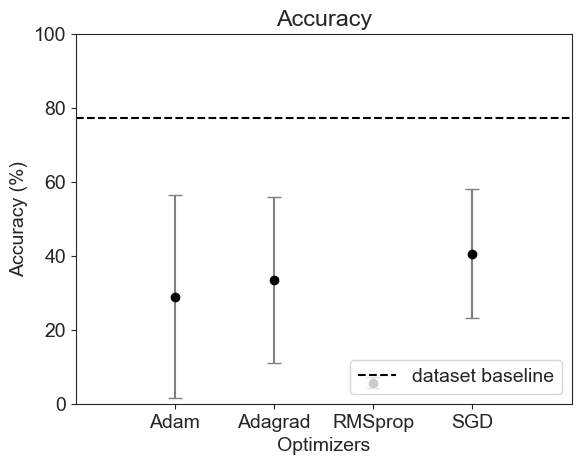

In [14]:
plt.errorbar('Adam', madam_acc, yerr=stdadam_acc, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('Adagrad', mada_acc, yerr=stadada_acc, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('RMSprop', mrmsprop_acc, yerr=stdrmsprop_acc, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('SGD', msgd_acc, yerr=stdsgd_acc, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)

plt.axhline(y = 77.4, color = 'k', linestyle = 'dashed',label = "dataset baseline")   

plt.xlabel('Optimizers')
plt.ylabel('Accuracy (%)')

plt.ylim(0,100)
plt.xlim(-1,4)
#plt.yticks(np.arange(20,101,10))
plt.title('Accuracy')

plt.legend(loc='lower right')

plt.show()

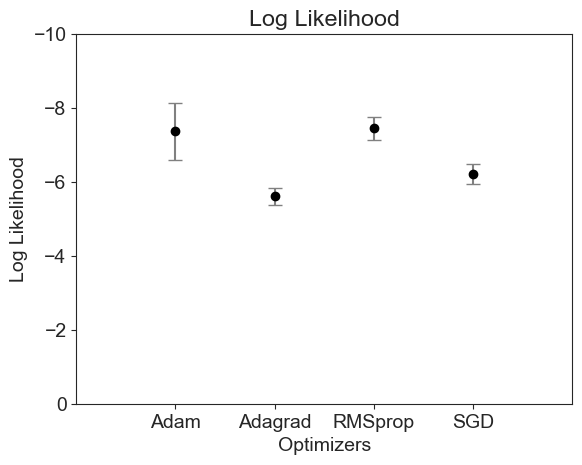

In [33]:
plt.errorbar('Adam', madam, yerr=stdadam, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('Adagrad', mada, yerr=stadada, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('RMSprop', mrmsprop, yerr=stdrmsprop, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('SGD', msgd, yerr=stdsgd, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)

plt.ylim(0,-10)
plt.xlim(-1,4)

plt.xlabel('Optimizers')
plt.ylabel('Log Likelihood')

#plt.yticks([-10,0,madam,mada,mrmsprop,msgd])#minor=True
plt.title('Log Likelihood')

plt.show()

In [9]:
data, fname = load_data(CASE=1)

In [10]:
rbm_1 = rbm(data,hidden_units=3,
            SPINS=True,
            random_seed=220)

Loaded N=10000 data instances each containing L=20 digits


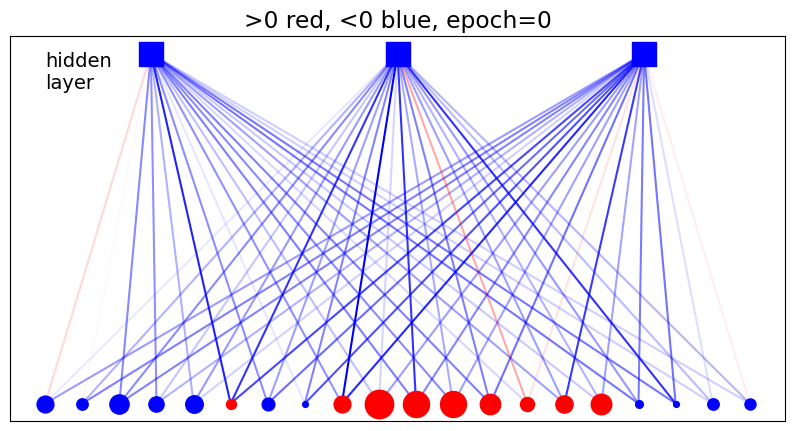

learning rate =  0.005
epoch:  1
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.938
epoch:  2
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.939


In [12]:
rbm_1.train(epochs=2,
            one_hot=True,
            learning_rate=0.005,
            power_law=True,
            batch_size=500,
            cd=5,
            optimizer='adam',
            epsilon=2,
            keep_best=True,
            verbose=True)

In [15]:
rbm_1.v_dw

array([[1.59417331e-09, 6.73092907e-10, 4.31206525e-10],
       [2.84585768e-09, 2.38134704e-09, 3.60733162e-10],
       [1.13473394e-08, 5.22221464e-09, 4.56111519e-09],
       [6.14616335e-09, 2.37985711e-09, 3.55014909e-09],
       [5.54639909e-10, 4.87795803e-10, 3.96677674e-10],
       [1.13378770e-09, 2.38321297e-10, 5.04328705e-10],
       [1.36276549e-08, 7.21306196e-09, 1.07738616e-08],
       [1.38226956e-09, 9.84201932e-10, 1.26026442e-10],
       [1.05506832e-09, 5.28661156e-11, 4.39969258e-10],
       [2.82557673e-09, 2.34695441e-09, 1.05755025e-09],
       [4.04106109e-09, 1.87421162e-09, 2.64247570e-09],
       [4.72166866e-09, 3.77256879e-09, 3.02044114e-09],
       [1.02148425e-08, 6.70749982e-09, 2.60153224e-09],
       [3.73893746e-09, 7.50014381e-10, 6.38648585e-10],
       [2.43227279e-09, 2.12023814e-09, 1.41041966e-09],
       [3.30861976e-09, 1.73688533e-09, 5.21180782e-09],
       [4.76052757e-09, 4.36966593e-09, 4.65057688e-09],
       [6.70934964e-09, 1.67657

In [12]:
# Generating data
gen_data = rbm_1.generate(amplify=30,one_hot=True)

In [14]:
# Plotting the original and the generated (denoised) data
rbm_1.plot_denoised(fname,gen_data,n_rows=5,polar=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
2,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1
3,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0


In [15]:
rbm_1.accuracy(gen_data)

Percentage error in data: 22.6 %
Accuracy of the models prediction: 92.0 %


91.8

In [16]:
rbm_1.plot_denoised(fname,gen_data,n_rows=10,polar=True)

,0,1,2,3,4
0,P,N,P,N,P
1,P,N,P,N,P
2,P,N,P,N,P
3,N,P,N,P,N
4,P,P,N,P,N
5,P,N,P,N,P
6,P,N,P,N,N
7,P,N,P,N,P
8,N,P,N,N,N
9,P,N,P,N,P


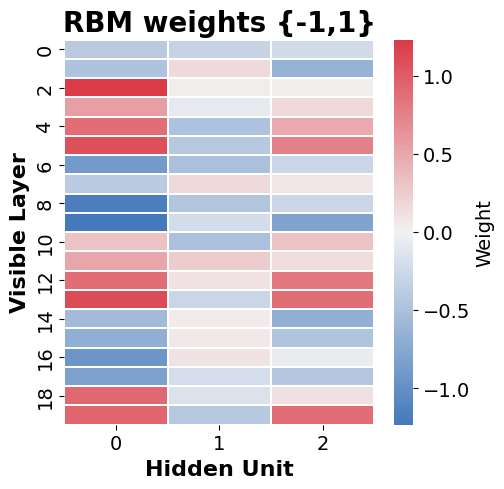

In [17]:
rbm_1.plot_weights(SPINS=True)

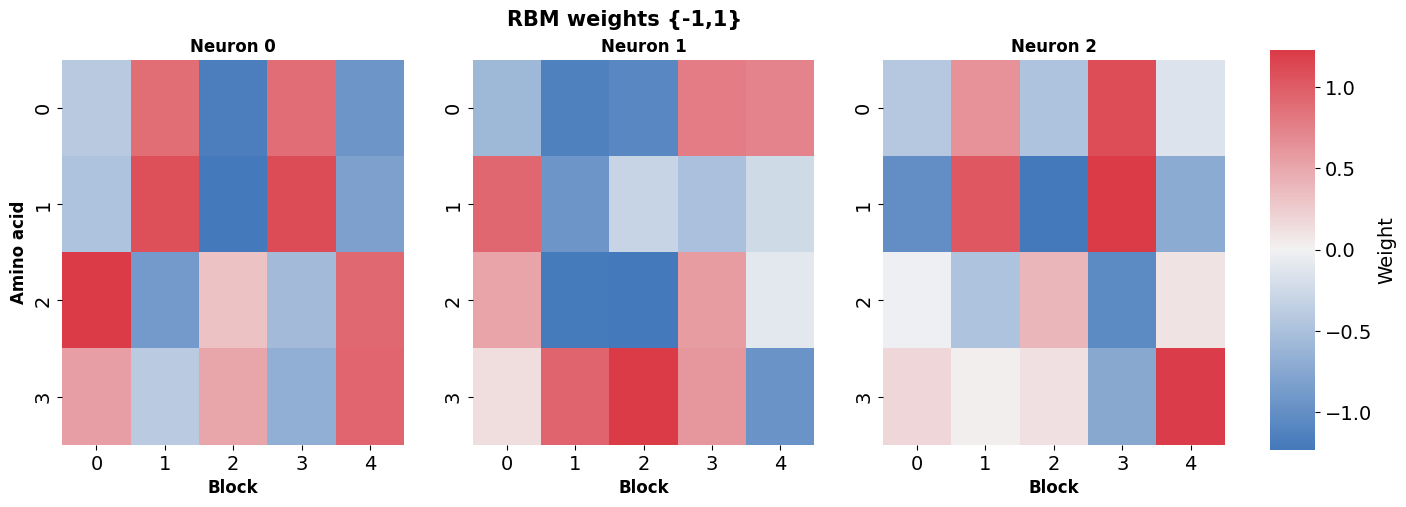

In [19]:
rbm_1.plot_weights_inblocks(SPINS=True)

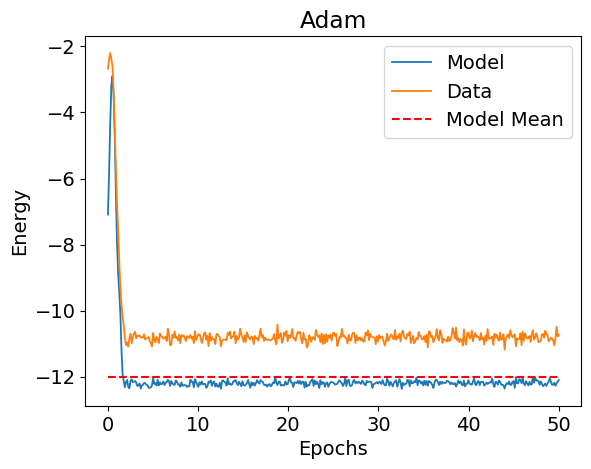

In [20]:
def plot_energies(model):  
    x = np.linspace(0,50,len(model.energy_model))
    mean = np.mean(model.energy_model)
    #asy = model.energy_model[-1]
        
    plt.plot(x,model.energy_model,label='Model', linewidth=1.3)
    plt.plot(x,model.energy_data,label='Data', linewidth=1.3)
    plt.plot(x,np.full(len(x),mean),'--',label='Model Mean',c='r',linewidth=1.5)
    #plt.plot(x,np.full(len(x),asy),'--',label='asy_model',c='y',linewidth=0.8)

    plt.title('Adam')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Energy')
    plt.show()
        
plot_energies(rbm_1)

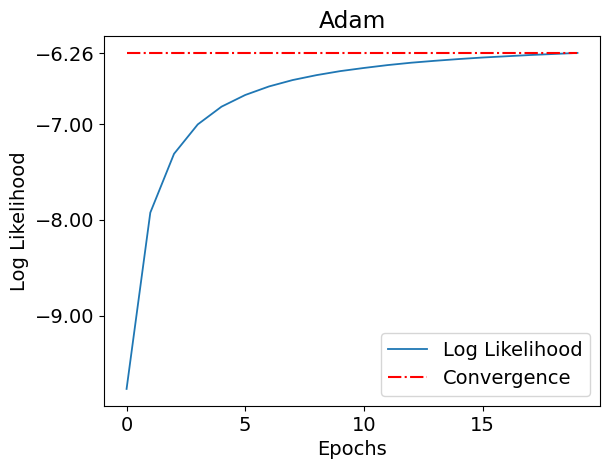

In [21]:
def plot_log_likelihood(model):
    x = np.arange(len(model.log_likelihood))
    mean = np.mean(model.log_likelihood)
    asy = model.log_likelihood[-1]
        
    plt.plot(model.log_likelihood,label='Log Likelihood', linewidth=1.3)
    plt.plot(x,np.full(len(x),asy),'-.',label='Convergence',c='red',linewidth=1.5)
    #plt.plot(x,np.full(len(x),mean),'--',label='mean_log_likelihood',c='orange',linewidth=1.5)
        
    plt.title('Adam')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Log Likelihood')
    plt.yticks([-9,-8,-7,model.log_likelihood[-1]])
    plt.show()

plot_log_likelihood(rbm_1)

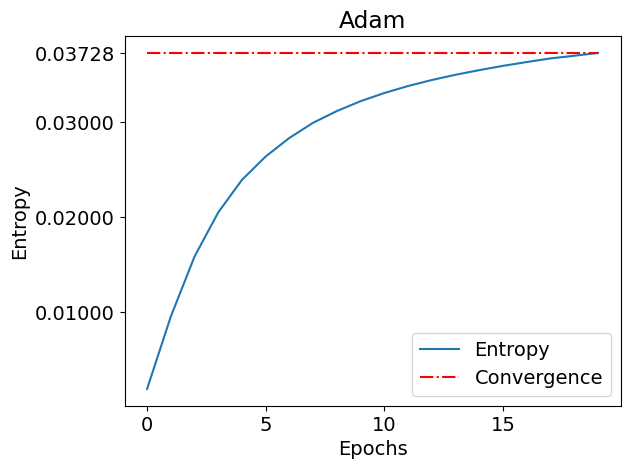

In [22]:
def plot_entropy(model):
    x = np.arange(len(model.entropy))
    mean = np.mean(model.entropy)
    asy = model.entropy[-1]
        
    plt.plot(model.entropy,label='Entropy')
    plt.plot(x,np.full(len(x),asy),'-.',label='Convergence',c='red',linewidth=1.5)
    #plt.plot(x,np.full(len(x),mean),'--',label='mean_entropy',c='orange',linewidth=1.5)
        
    plt.title('Adam')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Entropy')
    plt.yticks([0.01,0.02,0.03,model.entropy[-1]])
    plt.show()

plot_entropy(rbm_1)